# Detecting depression in Tweets 

# Installing and importing libraries

In [65]:
!pip install wordcloud
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import spacy
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions 
%matplotlib inline
spacy.cli.download("en_core_web_lg")


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Loading the Data

In [146]:
tweets = pd.read_csv(r"C:\Users\abdul\Downloads\project_Lab\Webappfordepressiondetectionontweets-main\Webappfordepressiondetectionontweets-main\sentiment_tweets33.csv")
tweets.head(20)

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,so sleepy. good times tonight though,0
6,"@SilkCharm re: #nbn as someone already said, d...",0
7,23 or 24ï¿½C possible today. Nice,0
8,nite twitterville workout in the am -ciao,0
9,"@daNanner Night, darlin'! Sweet dreams to you",0


In [111]:
tweets['label'].value_counts()

0    8000
1    3416
Name: label, dtype: int64

In [92]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11416 entries, 0 to 11415
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  11416 non-null  object
 1   label    11416 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 178.5+ KB


# Splitting the Data in Training and Testing Sets

As you can see, I used almost all the data for training: 98% and the rest for testing.

In [147]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [113]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11416 entries, 0 to 11415
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  11416 non-null  object
 1   label    11416 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 178.5+ KB


In [114]:
trainData['label'].value_counts()

0    7828
1    3350
Name: label, dtype: int64

In [115]:
trainData.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [116]:
testData['label'].value_counts()

0    172
1     66
Name: label, dtype: int64

In [117]:
testData.head()

,message,label
53,@ingorammer well it is definitelly worth tryin...,0
135,"Okay, have torn apart my work. Fresh coffee &a...",0
216,New Osalto blog post - http://tinyurl.com/dnbr...,0
257,"@brob108 good stuff Woop, looking forward to...",0
267,Anyone care to comment on last nights Hells Ki...,0


# Wordcloud Analysis

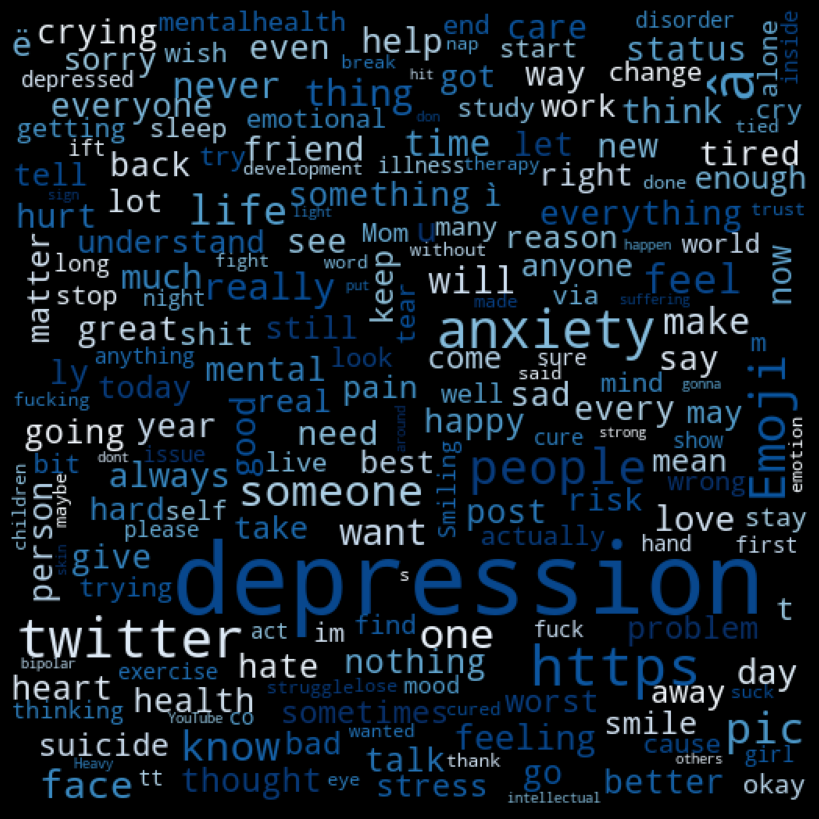

In [118]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

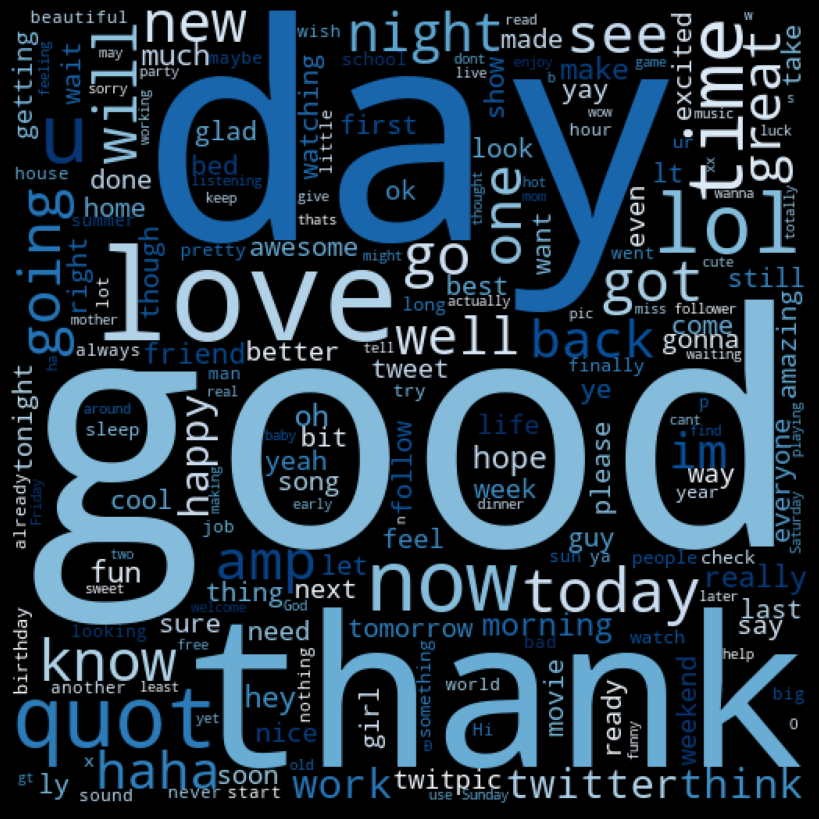

In [119]:
positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [148]:
def word_is_negated(word):
    """ """

    for child in word.children:
        if child.dep_ == 'neg':
            return True

    if word.pos_ in {'VERB'}:
        for ancestor in word.ancestors:
            if ancestor.pos_ in {'VERB'}:
                for child2 in ancestor.children:
                    if child2.dep_ == 'neg':
                        return True

    return False

def find_negated_wordSentIdxs_in_sent(sent, idxs_of_interest=None):
    """ """

    negated_word_idxs = set()
    for word_sent_idx, word in enumerate(sent):
        if idxs_of_interest:
            if word_sent_idx not in idxs_of_interest:
                continue
        if word_is_negated(word):
            negated_word_idxs.add(word_sent_idx)

    return negated_word_idxs

#Pre-processing the data for the training: Tokenization, stemming, and removal of stop words

In [149]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    #precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    #Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    #print("Precision: ", precision)
    print("Recall: ", recall)
   # print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [165]:

from sklearn.feature_extraction.text import CountVectorizer

x = []
y = []
z = []

vectorizer = TfidfVectorizer(stop_words='english')

for row in trainData['message']:
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    row = RE_EMOJI.sub(r'', row)
    row=contractions.fix(row)
    
    x.append(row)



for rows in trainData['label']:
    y.append(rows)
    
for col in testData['message']:
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    col = RE_EMOJI.sub(r'', col)
    col=contractions.fix(col)
    
    z.append(col)



In [184]:
from sklearn.svm import SVC
import pickle
start_timesvm = time.time()
train_featuressvm = vectorizer.fit_transform(x)
pickle.dump(train_featuressvm, open('vectorizer', "wb"))
actual2 = y
test_features2 = vectorizer.transform(z)
svc = SVC()
   
svc = svc.fit(train_featuressvm, [int(r) for r in y])
pickle.dump(svc, open('svm.pkl', 'wb'))

In [169]:
import numpy as np

#create numpy array with zeros
prediction2= np.zeros(500)
h=0
for row in z:
    j=find_negated_wordSentIdxs_in_sent(nlp(row))
    test_features2 = vectorizer.transform([row])
    prediction2[h] = svc.predict(test_features2)
    if (j != set()):
        prediction2[h]  = int(not(prediction2[h]))
    else:
        prediction2[h] = int(prediction2[h])
        
    h=h+1
metrics(testData['label'], prediction2)

Recall:  0.6438356164383562
Accuracy:  0.8047808764940239


In [170]:
pm = 'Fuck off man'
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = not(prediction2)
else:
    prediction2 = prediction2
print(prediction2)


[1]


In [171]:
pm = 'i am feeling Extreme sadness, lack of energy, hopelessness'
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = not(prediction2)
else:
    prediction2 = prediction2
print(prediction2)


[1]


In [172]:
pm = 'Hi hello depression and anxiety are the worst'
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = not(prediction2)
else:
    prediction2 = prediction2
print(prediction2)


[1]


In [173]:
pm = 'I am officially done with @kanyewest'
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = not(prediction2)
else:
    prediction2 = prediction2
print(prediction2)




[1]


In [174]:
pm = 'Feeling down...'
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = not(prediction2)
else:
    prediction2 = prediction2
print(prediction2)




[1]


In [175]:
pm = 'My depression will make me sad'
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = not(prediction2)
else:
    prediction2 = prediction2
print(prediction2)



[1]


# Positive Tweets

In [176]:
pm = 'I am not depressed.'
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)


test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  =int( not(prediction2))
else:
    prediction2 = prediction2
print(prediction2)


0


In [177]:
pm = ' i am not sad'
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
#print(j)
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = int(not(prediction2))
else:
    prediction2 = prediction2
print(prediction2)


0


In [178]:
pm = 'Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy'
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
#print(j)
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = int(not(prediction2))
else:
    prediction2 = prediction2
print(prediction2)



[0]


In [179]:
pm = 'RT @JonathanShrager: Rather than play Thursday’s game vs CFC, I propose we forfeit the 3 points, and instead place Ralf in centre circle at…'
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
col = RE_EMOJI.sub(r'', pm)
col=contractions.fix(pm)
j=find_negated_wordSentIdxs_in_sent(nlp(pm))
#print(j)
test_features2 = vectorizer.transform([pm])
prediction2 = svc.predict(test_features2)
if (j != set()):
    prediction2  = not(prediction2)
else:
    prediction2 = prediction2
print(prediction2)

[0]
